In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as matplt
%matplotlib inline

In [4]:
dataframes=list(pd.read_json(f) for f in ['Downloads/csgo-ai-competition-master/csgo-ai-competition-master/datasets/dataset/dataset_initial/dataset_{:02}.json'.format(i) for i in range(0,1)])

In [5]:
input_data=pd.concat(dataframes,ignore_index=True)
input_data=input_data.loc[input_data.alive_players.str.len()!=0,:]
input_data.reset_index(drop=True,inplace=True)

In [2]:
def get_series_from_dataset(ds,side,value=''):
    attrPlayers=map(lambda players:filter(lambda player:player['team']==side,players),ds['alive_players'])  
    if value!='':
        attrPlayers=map(lambda players:map(lambda player:player[value],players),attrPlayers)
    return list(map(list,attrPlayers))

In [3]:
def get_item_types_from_inventory(ds,side):
    values=map(lambda players:map(lambda objects:map(lambda object:object['item_type'],objects),players),get_series_from_dataset(ds,side,'inventory'))
    values=map(lambda players:map(lambda player:' '.join(player),players),values)
    return list(map(lambda p:' '.join(p),values))

In [6]:
def get_features_dataframe(ds):
    ds['dif_health']=(pd.Series(map(lambda p:sum(p),get_series_from_dataset(ds,'Terrorist','health')))-pd.Series(map(lambda p:sum(p),get_series_from_dataset(ds,'CT','health'))))
    ds['dif_armor']=(pd.Series(map(lambda p:sum(p),get_series_from_dataset(ds,'Terrorist','armor')))-pd.Series(map(lambda p:sum(p),get_series_from_dataset(ds,'CT','armor'))))
    no_ct_players=pd.Series(map(lambda p:len(p),get_series_from_dataset(ds,'CT')))
    ds['dif_no_of_players']=(pd.Series(map(lambda p:len(p),get_series_from_dataset(ds,'Terrorist')))-no_ct_players)
    ds['money_ct']=(pd.Series(map(lambda p:sum(p),get_series_from_dataset(ds,'CT','money')))/no_ct_players)
    ds['inventory_ct']=get_item_types_from_inventory(ds,'CT')
    ds['inventory_t']=get_item_types_from_inventory(ds,'Terrorist')
    ds['has_kit']=pd.Series(map(lambda p:any(p),get_series_from_dataset(ds,'CT','has_defuser')))
    ds.round_status_time_left[ds.round_status=='FreezeTime']/=20
    ds.round_status_time_left[ds.round_status=='Normal']/=115
    ds.round_status_time_left[ds.round_status=='BombPlanted']/=40
    return ds[['dif_health','dif_armor','dif_no_of_players','inventory_t','inventory_ct','round_status_time_left','round_status','has_kit','money_ct','map']]

In [13]:
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.pipeline import make_pipeline
s_words=['c4','glock','p2000','usps']
cntVec=CountVectorizer(stop_words=s_words)
sc=StandardScaler()
le=LabelEncoder()
colTrans=ColumnTransformer(transformers=([('scaling',sc,make_column_selector(pattern='dif|time|money')),('ct_cnt_vectorizer',cntVec,'inventory_ct'),('t_cnt_vectorizer',cntVec,'inventory_t'),('round_status_encoder',OneHotEncoder(),['round_status']),('map_encoder',OneHotEncoder(),['map'])]),remainder='passthrough')

In [14]:
X=get_features_dataframe(input_data)
y=le.fit_transform(input_data.round_winner)

C:\Users\Sriram\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Sriram\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Sriram\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

map                       False
patch_version             False
map_crc                   False
current_score             False
round_status              False
round_status_time_left    False
alive_players             False
active_smokes             False
active_molotovs           False
previous_kills            False
round_winner              False
planted_bomb               True
dif_health                False
dif_armor                 False
dif_no_of_players         False
money_ct                  False
inventory_ct              False
inventory_t               False
has_kit                   False
dtype: bool

In [8]:
train_imggen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,width_shift_range=0.2,height_shift_range=0.2)
test_imggen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
img_name='Downloads/csgo-ai-competition-master/csgo-ai-competition-master/round_snapshots/training/dataset_{}.jpg'
image_data=[]
batch=64
for i in range(0,1):
    image=tf.keras.preprocessing.image.load_img(path=img_name.format(i),target_size=(64,64))
    image_data.append(tf.keras.preprocessing.image.img_to_array(image))
image_data=np.array(image_data)
#num_input_data=colTrans.fit_transform(X).toarray()

In [16]:
for i in range(image_data.shape[1]):
    print(image_data[0][i][53][0],image_data[0][i][53][1],image_data[0][i][53][2])

0.0 0.0 0.0
0.0 0.0 0.0
40.0 47.0 63.0
39.0 48.0 65.0
39.0 48.0 65.0
243.0 250.0 255.0
40.0 47.0 63.0
40.0 47.0 63.0
39.0 48.0 65.0
39.0 48.0 63.0
37.0 49.0 65.0
243.0 247.0 255.0
41.0 47.0 59.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
37.0 48.0 66.0
37.0 48.0 66.0
37.0 48.0 66.0
37.0 48.0 66.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 47.0 66.0
37.0 48.0 66.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
39.0 48.0 65.0
40.0 47.0 65.0
39.0 48.0 63.0
39.0 48.0 63.0
39.0 48.0 63.0
39.0 48.0 63.0
39.0 48.0 63.0
236.0 247.0 255.0
34.0 53.0 60.0
255.0 253.0 255.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0


In [25]:
from sklearn.model_selection import train_test_split
num_input_data_train,num_input_data_test,image_data_train,image_data_test,y_train,y_test=train_test_split(num_input_data,image_data,y,random_state=33,train_size=0.8)

In [26]:
def combined_generator(X1, X2, y,gen):
    gen1 = gen.flow(X1,y,  batch_size=batch,seed=33)
    gen2 = gen.flow(X1,X2, batch_size=batch,seed=33)
    while True:
            X1 = gen1.next()
            X2 = gen2.next()
            yield [X1[0], X2[1]], X1[1]

In [27]:
input_gen=combined_generator(image_data_train,num_input_data_train,y_train,train_imggen)
validation_gen=combined_generator(image_data_test,num_input_data_test,y_test,test_imggen)

In [32]:
inputs=tf.keras.Input(shape=(64,64,3),name='input_img')
num_data_input=tf.keras.Input(shape=(num_input_data_train.shape[1],),name='num_input')
x=tf.keras.layers.Conv2D(32,3,activation='relu',name='Convolution1',padding='same')(inputs)
#x=tf.keras.layers.LayerNormalization()(x)
x=tf.keras.layers.Conv2D(32,3,activation='relu',name='Convolution2',padding='same')(x)
#x=tf.keras.layers.LayerNormalization()(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,name='Pooling1')(x)
x=tf.keras.layers.Conv2D(64,3,activation='relu',name='Convolution3',padding='same')(x)
#x=tf.keras.layers.LayerNormalization()(x)
x=tf.keras.layers.Conv2D(64,3,activation='relu',name='Convolution4',padding='same')(x)
#x=tf.keras.layers.LayerNormalization()(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding='same',name='Pooling2')(x)
x=tf.keras.layers.Conv2D(128,3,activation='relu',name='Convolution5',padding='same')(x)
#x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(128,3,activation='relu',name='Convolution6',padding='same')(x)
#x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D(pool_size=2,strides=2,padding='same',name='Pooling3')(x)
img_output=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Concatenate()([img_output,num_data_input])
x=tf.keras.layers.Dropout(0.2)(x)
#x=tf.keras.layers.Dense(1024,activation='relu')(x)
#x=tf.keras.layers.Dropout(0.15)(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)

Model: "img_feature_gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Convolution1 (Conv2D)           (None, 64, 64, 32)   896         input_img[0][0]                  
__________________________________________________________________________________________________
Convolution2 (Conv2D)           (None, 64, 64, 32)   9248        Convolution1[0][0]               
__________________________________________________________________________________________________
Pooling1 (MaxPooling2D)         (None, 32, 32, 32)   0           Convolution2[0][0]               
____________________________________________________________________________________

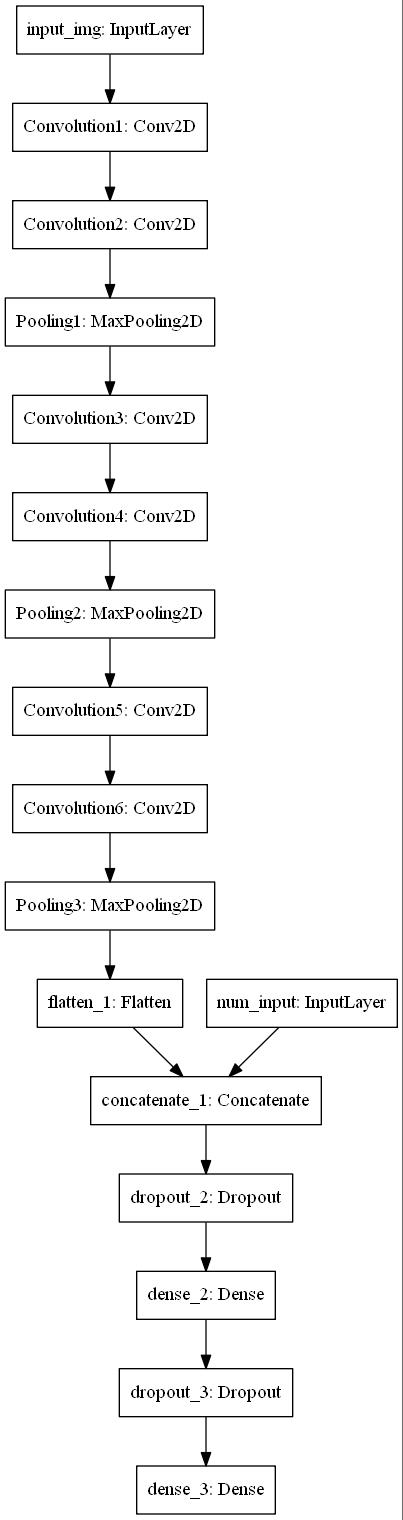

In [33]:
conv_model=tf.keras.Model([inputs,num_data_input],outputs,name='img_feature_gen')
conv_model.summary()
tf.keras.utils.plot_model(conv_model,'conv_model1.jpg')

In [35]:
conv_model.compile(loss='binary_crossentropy',metrics=['AUC','accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model_param=conv_model.fit(input_gen,epochs=100,validation_data=validation_gen,validation_steps=len(num_input_data_test)//batch,steps_per_epoch=len(num_input_data_train)//batch)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 15 steps
Epoch 1/25
63/63 [==============================] - 85s 1s/step - loss: 0.3509 - AUC: 0.9210 - accuracy: 0.8354 - val_loss: 0.3902 - val_AUC: 0.9030 - val_accuracy: 0.8251
Epoch 2/25
63/63 [==============================] - 72s 1s/step - loss: 0.3415 - AUC: 0.9260 - accuracy: 0.8401 - val_loss: 0.4058 - val_AUC: 0.9015 - val_accuracy: 0.8104
Epoch 3/25
63/63 [==============================] - 69s 1s/step - loss: 0.3506 - AUC: 0.9223 - accuracy: 0.8394 - val_loss: 0.3819 - val_AUC: 0.9117 - val_accuracy: 0.8293
Epoch 4/25
63/63 [==============================] - 75s 1s/step - loss: 0.3207 - AUC: 0.9347 - accuracy: 0.8539 - val_loss: 0.4001 - val_AUC: 0.8958 - val_accuracy: 0.8126
Epoch 5/25
35/63 [===============>..............] - ETA: 33s - loss: 0.3657 - AUC: 0.9135 - accuracy: 0.8189

KeyboardInterrupt: 

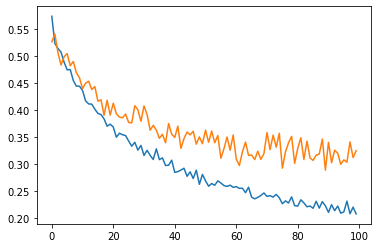

In [32]:
matplt.pyplot.plot(range(0,100),model_param.history.get('loss'),model_param.history.get('val_loss'))#3072

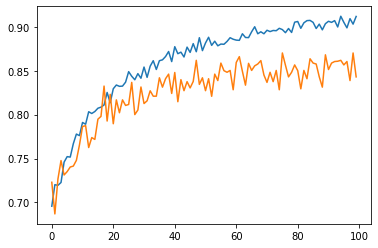

In [33]:
matplt.pyplot.plot(range(0,100),model_param.history.get('accuracy'),model_param.history.get('val_accuracy'))#3072

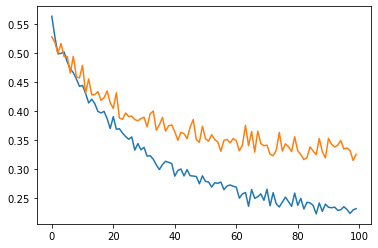

In [37]:
matplt.pyplot.plot(range(0,100),model_param.history.get('loss'),model_param.history.get('val_loss'))#2048

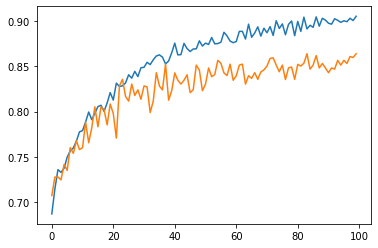

In [38]:
matplt.pyplot.plot(range(0,100),model_param.history.get('accuracy'),model_param.history.get('val_accuracy'))#2048

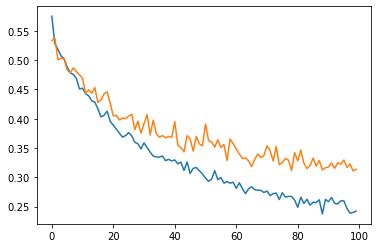

In [42]:
matplt.pyplot.plot(range(0,100),model_param.history.get('loss'),model_param.history.get('val_loss'))#1024

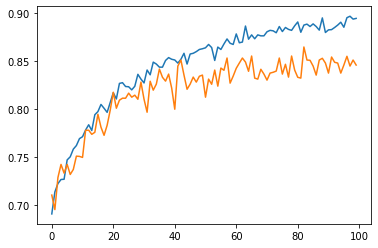

In [43]:
matplt.pyplot.plot(range(0,100),model_param.history.get('accuracy'),model_param.history.get('val_accuracy'))#1024

In [ ]:
matplt.pyplot.plot(range(0,100),model_param.history.get('loss'),model_param.history.get('val_loss'))#1024#1024

In [ ]:
matplt.pyplot.plot(range(0,100),model_param.history.get('accuracy'),model_param.history.get('val_accuracy'))#1024#1024

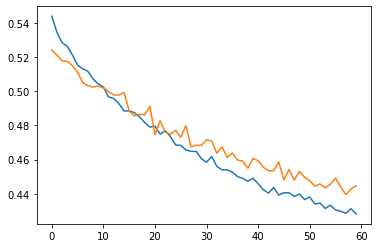

In [82]:
matplt.pyplot.plot(range(0,60),model_param.history.get('loss'),model_param.history.get('val_loss'))#final1024all

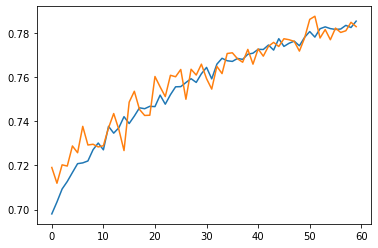

In [83]:
matplt.pyplot.plot(range(0,60),model_param.history.get('accuracy'),model_param.history.get('val_accuracy'))#final1024all

In [84]:
conv_model.save('csgo-ai-1024-half')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: csgo-ai-1024-half\assets


In [ ]:
csgo_ai_half=tf.keras.load_model('csgo-ai-1024-half')